## Reflektionsfrågor

### 1. Hur har du upplevt arbetet med projektet?

Projektet har varit lärorikt att kombinera maskininlärning med aktiehandel. Att kunna jämföra avkastning från buy-and-hold mot AI-modellens köp/säljsignaler var spännande, och gav insikt i om det är en rimlig strategi för att handla aktier på aktiemarknaden.

### 2. Har något varit utmanande, hur har du hanterat det? Vilka lärdomar har du tagit?

**Feature engineering** var utmanande då modellen endast baseras på teknisk analys och inte fundamental analys. Svårt att veta vilka tekniska indikatorer som är relevanta. Jag löste det genom att utvärdera feature importance för att se vilka indikatorer som påverkar modellen mest.

**Look-ahead bias** var också ett problem, då det hade gjort modellen värdelös. Jag behövde säkerställa att modellen inte tränades på data som sedan skulle användas för utvärdering. Använde time-based split och `.shift(1)` för positioner.

**Lärdomar:**
- Historisk prestanda garanterar inte framtida resultat
- Time-series data kräver speciell validering
- Att slå Buy & Hold är mycket svårt

### 3. Vilket betyg anser du att du ska ha?

**VG** baserat på:
- 40+ features från olika kategorier av tekniska indikatorer
- Tydliga visualiseringar (equity curves, feature importance, trading signals)
- Helhetsjämförelse över 10 aktier samt per-aktie analys
- Korrekt backtesting utan data leakage
- Jämförelse mot Buy & Hold benchmark

### 4. Övrigt som du vill reflektera kring?

Hade velat tweaka modellen ännu mer med grid-search för hyperparameters och optimera threshold-värden för att hitta den nivå som ger bäst avkastning.

Det hade varit intressant med ett större dataset som hela S&P 500, vilket skulle lett till en mer robust modell med färre avvikelser. Ursprungsplanen var att träna på ett stort dataset, sedan välja en specifik aktie eller sektor att analysera djupare. Där hade jag velat lägga till fundamental analys (om aktien är under/övervärderad) och även låta modellen följa nyheter i den specifika sektorn. Men det verkade överambitiöst, så jag höll mig till KISS-principen (Keep It Simple, Stupid).

In [1]:
%pip install -q yfinance pandas numpy scikit-learn xgboost ta matplotlib seaborn joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np 
import os, time
import yfinance as yf
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import ta 
import matplotlib.pyplot as plt 
import seaborn as sns
import joblib

plt.style.use('seaborn-v0_8-darkgrid')
print("Bibliotek importerade")

Bibliotek importerade


In [3]:
TICKERS = ["AAPL", "MSFT", "NVDA", "AMZN", "TSLA", "META", "JPM", "XOM", "NFLX", "GOOGL"]
START_DATE = "2015-01-01"
END_DATE = "2025-01-01"
DATA_DIR = "data_csv"
PICKLE_PATH = "stock_prices.pkl"

os.makedirs(DATA_DIR, exist_ok=True)
DOWNLOAD_DATA = False#Sätt till True för att ladda ner ny data

# Nedladdning (endast om DOWNLOAD_DATA=True)
if DOWNLOAD_DATA:
    print("Laddar ner aktiedata...")
    for ticker in TICKERS:
        filepath = os.path.join(DATA_DIR, f"{ticker}_{START_DATE}_{END_DATE}.csv")
        if os.path.exists(filepath):
            print(f"{ticker} redan nedladdad")
            continue

        print (f" Laddar ner {ticker}...")
        df = yf.download(ticker, start=START_DATE, end=END_DATE, auto_adjust=True,
            threads=False, progress=False)
        if df is not None and not df.empty:
            df = df.rename(columns=str.title).reset_index()
            df["Symbol"] = ticker
            df.to_csv(filepath, index=False)
        time.sleep(2)
    print("Nedladdning klar")
else:
    print("Använder cachad data")

# Ladda och kombinera data
if os.path.exists(PICKLE_PATH):
    stock_data = pd.read_pickle(PICKLE_PATH)
    print(f" Data laddad från {PICKLE_PATH}")
else:
    csv_files = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
    if not csv_files:
        raise FileNotFoundError(f"Inga CSV-filer i {DATA_DIR}. Sätt DOWNLOAD_DATA=True")

    dataframes = [pd.read_csv(os.path.join(DATA_DIR, f)) for f in csv_files]
    stock_data = pd.concat(dataframes, ignore_index=True)
    stock_data["Date"] = pd.to_datetime(stock_data["Date"])
    stock_data = stock_data.dropna(subset=["Date", "Close"])
    stock_data = stock_data.sort_values(["Symbol", "Date"]).reset_index(drop=True)
    stock_data.to_pickle(PICKLE_PATH)
    print(f"Data sparad till {PICKLE_PATH}")

print(f"\nRader: {len(stock_data):,} | Aktier: {stock_data['Symbol'].nunique()} | "
      f"Period: {stock_data['Date'].min().date()} → {stock_data['Date'].max().date()}")

Använder cachad data
 Data laddad från stock_prices.pkl

Rader: 25,160 | Aktier: 10 | Period: 2015-01-02 → 2024-12-31


## Feature Engineering
### Skapar 40+ tekniska indikatorer som features

In [4]:
def create_features(data):
    results = []
    
    for symbol, group in data.groupby("Symbol"):
        # Convert string columns to numeric
        numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
        group = group.copy()
        for col in numeric_cols:
            group[col] = pd.to_numeric(group[col], errors='coerce')
        
        # Calculate returns
        group["return_1d"] = group["Close"].pct_change()
        
        # RSI
        group["rsi_14"] = ta.momentum.RSIIndicator(group["Close"]).rsi()
        
        # Bollinger Bands
        bb = ta.volatility.BollingerBands(group["Close"], window=20)
        group["bb_high"] = bb.bollinger_hband()
        group["bb_low"] = bb.bollinger_lband()
        group["bb_mid"] = bb.bollinger_mavg()
        group["bb_width"] = (group["bb_high"] - group["bb_low"]) / group["bb_mid"]
        group["bb_position"] = (
            (group["Close"] - group["bb_low"]) /
            (group["bb_high"] - group["bb_low"]).replace(0, np.nan)
        )

        
        # Övriga indikatorer
        stoch = ta.momentum.StochasticOscillator(group["High"], group["Low"], group["Close"])
        group["stoch_k"] = stoch.stoch()
        group["stoch_d"] = stoch.stoch_signal()
        group["adx"] = ta.trend.ADXIndicator(group["High"], group["Low"], group["Close"]).adx()
        group["atr"] = ta.volatility.AverageTrueRange(group["High"], group["Low"], group["Close"]).average_true_range()
        group["cci"] = ta.trend.CCIIndicator(group["High"], group["Low"], group["Close"]).cci()
        group["williams_r"] = ta.momentum.WilliamsRIndicator(group["High"], group["Low"], group["Close"]).williams_r()
        group["obv"] = ta.volume.OnBalanceVolumeIndicator(group["Close"], group["Volume"]).on_balance_volume()
        group["obv_change"] = group["obv"].pct_change().clip(-5, 5)
        
        # Lag features
        for lag in [1, 2, 3, 5]:
            group[f"return_1d_lag{lag}"] = group["return_1d"].shift(lag)
            group[f"rsi_14_lag{lag}"] = group["rsi_14"].shift(lag)
        
        # Target: Nästa dags avkastning
        group["target_return"] = group["Close"].shift(-1) / group["Close"] - 1
        group["target"] = (group["target_return"] > 0).astype(int)

        group = group.dropna().reset_index(drop=True)
        
        results.append(group)
    
    return pd.concat(results, ignore_index=True)

print("Skapar features...")
stock_data_fe = create_features(stock_data)

feature_cols = [c for c in stock_data_fe.columns 
                if c not in ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'target', 'target_return']]
print(f"✓ {len(feature_cols)} features skapade")
print(f"  Exempel: {feature_cols[:8]}")

Skapar features...
✓ 23 features skapade
  Exempel: ['return_1d', 'rsi_14', 'bb_high', 'bb_low', 'bb_mid', 'bb_width', 'bb_position', 'stoch_k']


## Data Split
### 80% träning, 20% validering

In [6]:
train_parts = []
val_parts = []

for symbol, group in stock_data_fe.groupby("Symbol"):
    split = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split])
    val_parts.append(group.iloc[split:])

train_data = pd.concat(train_parts).reset_index(drop=True)
val_data = pd.concat(val_parts).reset_index(drop=True)

X_train, y_train = train_data[feature_cols], train_data["target"]
X_val, y_val = val_data[feature_cols], val_data["target"]

print("Train period:", train_data["Date"].min().date(), "→", train_data["Date"].max().date())
print("Val period:", val_data["Date"].min().date(), "→", val_data["Date"].max().date())

print("\nTrain class balance:")
print(y_train.value_counts(normalize=True))

print("\nVal class balance:")
print(y_val.value_counts(normalize=True))

Train period: 2015-01-30 → 2023-01-03
Val period: 2023-01-04 → 2024-12-30

Train class balance:
target
1    0.522194
0    0.477806
Name: proportion, dtype: float64

Val class balance:
target
1    0.5434
0    0.4566
Name: proportion, dtype: float64


## Modellträning: XGboost
### XGBoost valdes för dess styrka på strukturerad data och förmåga att hantera komplexa samband

In [7]:
print("Tränar XGBoost-modell...")

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_val_proba = model.predict_proba(X_val)[:, 1]
threshold = 0.55
val_signal = (y_val_proba > threshold).astype(int)

val_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validerings-AUC: {val_auc:.4f}")
print(f"Signal-frekvens: {val_signal.mean():.2%}")

joblib.dump(model, 'trading_model.pkl')

Tränar XGBoost-modell...
Validerings-AUC: 0.4884
Signal-frekvens: 28.54%


['trading_model.pkl']


Topp 15 viktigaste features:
       feature  importance
    williams_r    0.049338
        bb_mid    0.046823
           cci    0.045255
       stoch_d    0.044773
return_1d_lag1    0.044684
return_1d_lag3    0.044623
   rsi_14_lag1    0.044610
           atr    0.044184
        rsi_14    0.044159
return_1d_lag5    0.043775
    obv_change    0.043692
   rsi_14_lag5    0.043686
        bb_low    0.043518
   bb_position    0.043357
   rsi_14_lag3    0.042935


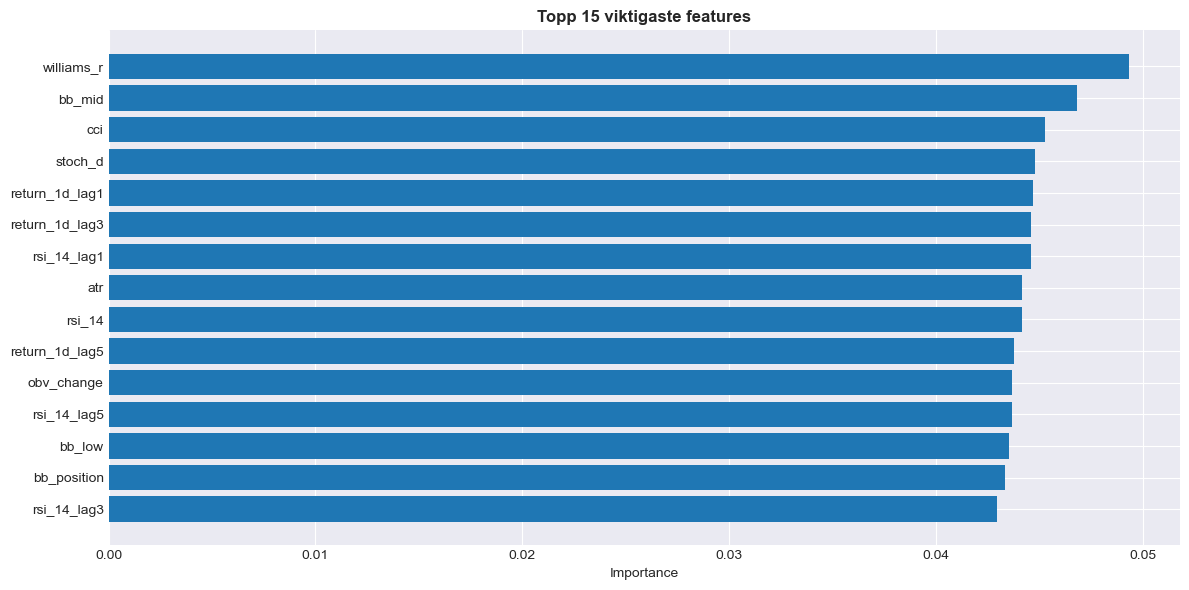

In [8]:
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTopp 15 viktigaste features:")
print(importance_df.head(15).to_string(index=False))

# Visualisera 
plt.figure(figsize=(12, 6))
top_15 = importance_df.head(15)
plt.barh(top_15['feature'], top_15['importance'])
plt.xlabel('Importance')
plt.title('Topp 15 viktigaste features', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Trading strategi utvärdering 

In [9]:
def evaluate_trading_strategy(df, probabilities, start_date='2024-01-01', end_date='2025-01-01', threshold_high=0.55, fee_bps=1.0):
    result = df.copy()
    result['prob'] = probabilities
    
    # Förbered data
    result['Date'] = pd.to_datetime(result['Date'])
    mask = (result['Date'] >= start_date) & (result['Date'] <= end_date)
    result = result.loc[mask].copy()
    
    # Beräkna avkastning per aktie
    result['daily_ret'] = result.groupby('Symbol')['Close'].pct_change()
    result['signal'] = np.where(result['prob'] >= threshold_high, 1, 0)
    result['position'] = result.groupby('Symbol')['signal'].shift(1).fillna(0)
    
    result['trades'] = result.groupby('Symbol')['position'].diff().abs().fillna(0)
    result['costs'] = result['trades'] * (fee_bps / 10000.0)
    
    result['ai_ret'] = (result['position'] * result['daily_ret']) - result['costs']
    result['bnh_ret'] = result['daily_ret']

    result = result.dropna(subset=['daily_ret', 'position'])

    # === ANALYS PER AKTIE ===
    stock_stats = []
    for symbol in sorted(result['Symbol'].unique()):
        s = result[result['Symbol'] == symbol]
        
        # Beräkna total avkastning (%)
        ai_val = ((1 + s['ai_ret']).prod() - 1) * 100
        bnh_val = ((1 + s['bnh_ret']).prod() - 1) * 100
        
        # Beräkna exponering (hur ofta var vi i marknaden?)
        exposure = s['position'].mean() * 100
        
        stock_stats.append({
            'Symbol': symbol,
            'AI_Return_%': ai_val,
            'BNH_Return_%': bnh_val,
            'Alpha_%': ai_val - bnh_val,
            'Exposure_%': exposure
        })

    # === PORTFÖLJ-NIVÅ ===
    portfolio = result.groupby('Date')[['ai_ret', 'bnh_ret']].mean()
    ai_cum = (1 + portfolio['ai_ret']).cumprod()
    bnh_cum = (1 + portfolio['bnh_ret']).cumprod()

    return {
        'ai_total': (ai_cum.iloc[-1] - 1) * 100 if not ai_cum.empty else 0,
        'bnh_total': (bnh_cum.iloc[-1] - 1) * 100 if not bnh_cum.empty else 0,
        'stock_summary': pd.DataFrame(stock_stats),
        'result_df': result
    }

START = '2024-01-01'
SLUT  = '2025-01-01'
metrics = evaluate_trading_strategy(val_data, y_val_proba, start_date=START, end_date=SLUT)

print("\n" + "="*85)
print(f"{'STRATEGIUTVÄRDERING: ' + START + ' till ' + SLUT:^85}")
print("="*85)
print(f"{'Symbol':<10} | {'AI Return':>12} | {'Buy & Hold':>12} | {'Alpha':>12} | {'Exponering':>12}")
print("-" * 85)

for _, row in metrics['stock_summary'].iterrows():
    print(f"{row['Symbol']:<10} | {row['AI_Return_%']:>11.2f}% | {row['BNH_Return_%']:>11.2f}% | {row['Alpha_%']:>11.2f}% | {row['Exposure_%']:>11.1f}%")

print("-" * 85)
print(f"{'TOTAL PORTFÖLJ':<10} | {metrics['ai_total']:>11.2f}% | {metrics['bnh_total']:>11.2f}% | {metrics['ai_total'] - metrics['bnh_total']:>11.2f}% | {'N/A':>12}")
print("="*85)


                   STRATEGIUTVÄRDERING: 2024-01-01 till 2025-01-01                   
Symbol     |    AI Return |   Buy & Hold |        Alpha |   Exponering
-------------------------------------------------------------------------------------
AAPL       |        2.76% |       36.52% |      -33.76% |        28.0%
AMZN       |       26.40% |       47.60% |      -21.21% |        38.4%
GOOGL      |       -2.74% |       38.91% |      -41.65% |        29.6%
JPM        |       18.54% |       42.40% |      -23.86% |        26.8%
META       |        6.09% |       71.39% |      -65.29% |        32.0%
MSFT       |        3.06% |       15.41% |      -12.34% |        26.0%
NFLX       |       20.78% |       92.19% |      -71.42% |        23.2%
NVDA       |       42.73% |      185.52% |     -142.79% |        14.8%
TSLA       |       72.72% |       68.03% |        4.70% |        38.8%
XOM        |        2.72% |        6.85% |       -4.12% |        30.0%
----------------------------------------------

## Visualiseringar 

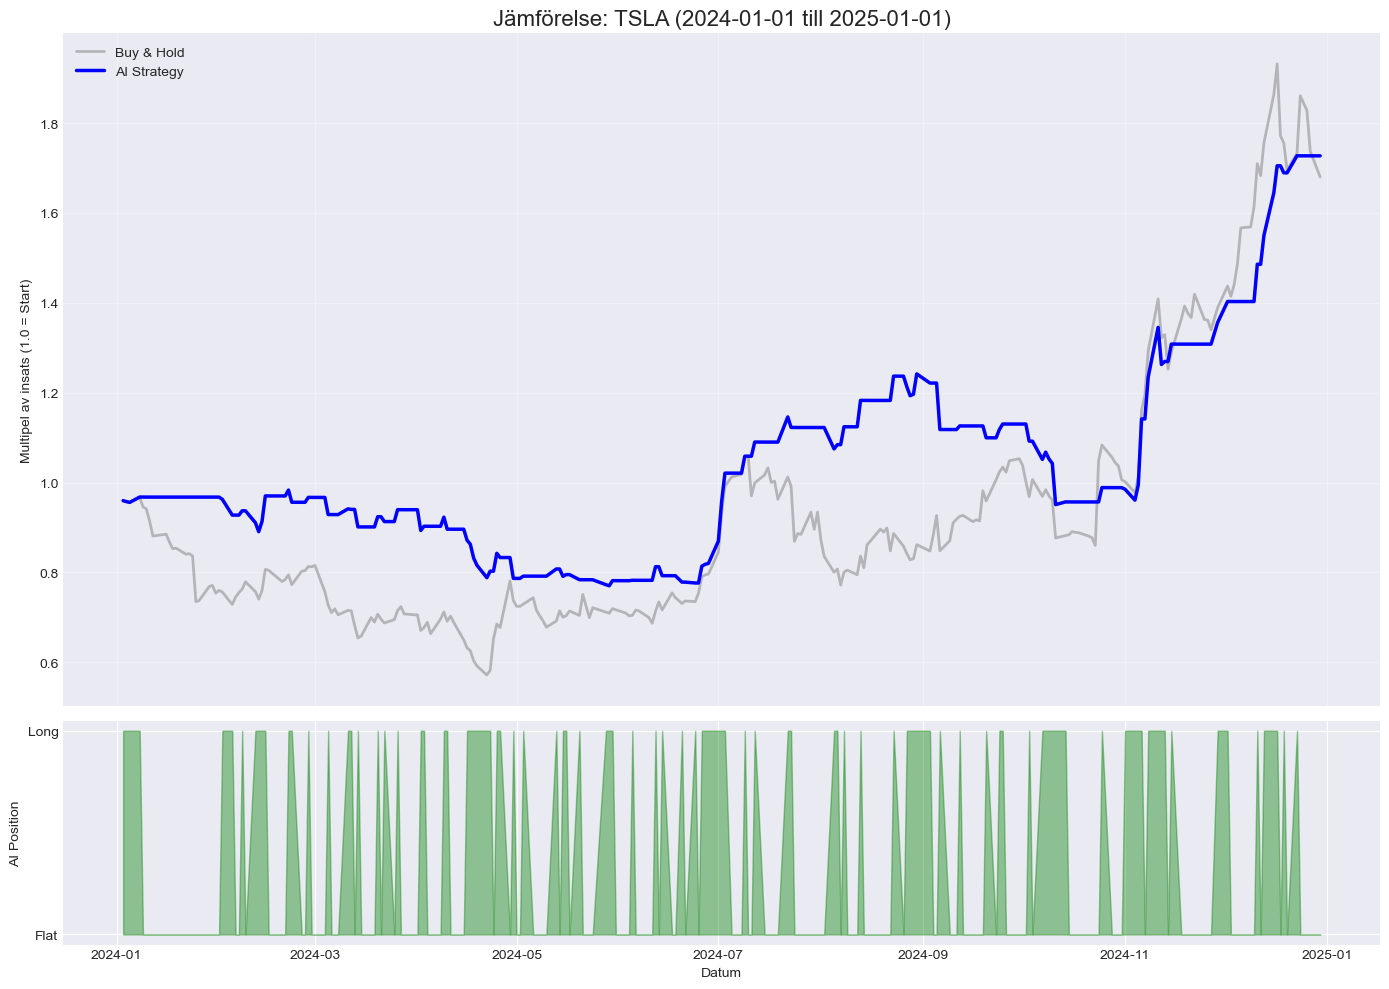

RESULTAT FÖR TSLA:
Buy & Hold: 68.03%
AI Strategy: 72.72%
Antal dagar AI var i marknaden: 97.0 av 250 dagar


In [11]:
# --- INSTÄLLNINGAR ---
valda_aktie = 'TSLA'  # Ändra till 'TSLA', 'META', etc.
start_datum = '2024-01-01'
slut_datum   = '2025-01-01'

# 1. Hämta resultaten från din senaste körning
full_df = metrics['result_df'].copy()
full_df['Date'] = pd.to_datetime(full_df['Date'])

stock_df = full_df[(full_df['Symbol'] == valda_aktie) & 
                   (full_df['Date'] >= start_datum) & 
                   (full_df['Date'] <= slut_datum)].sort_values('Date')

stock_df['ai_cum'] = (1 + stock_df['ai_ret']).cumprod()
stock_df['bnh_cum'] = (1 + stock_df['bnh_ret']).cumprod()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

ax1.plot(stock_df['Date'], stock_df['bnh_cum'], label='Buy & Hold', color='gray', alpha=0.5, lw=2)
ax1.plot(stock_df['Date'], stock_df['ai_cum'], label='AI Strategy', color='blue', lw=2.5)
ax1.set_title(f'Jämförelse: {valda_aktie} ({start_datum} till {slut_datum})', fontsize=16)
ax1.set_ylabel('Multipel av insats (1.0 = Start)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Undre graf: Position (När äger vi aktien?)
# Vi fyller ytan när position är 1
ax2.fill_between(stock_df['Date'], 0, stock_df['position'], color='green', alpha=0.4, label='AI: Long')
ax2.set_ylabel('AI Position')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Flat', 'Long'])
ax2.set_xlabel('Datum')

plt.tight_layout()
plt.show()

final_ai = (stock_df['ai_cum'].iloc[-1] - 1) * 100
final_bnh = (stock_df['bnh_cum'].iloc[-1] - 1) * 100
print(f"RESULTAT FÖR {valda_aktie}:")
print(f"Buy & Hold: {final_bnh:.2f}%")
print(f"AI Strategy: {final_ai:.2f}%")
print(f"Antal dagar AI var i marknaden: {stock_df['position'].sum()} av {len(stock_df)} dagar")